<a href="https://www.kaggle.com/code/dimasjackson/housing-prices-predictions?scriptVersionId=113481567" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Housing Prices Predictions

### Abstract

This notebook is a compilation of the knowledge from Kaggle Machine Learning courses to generate a better submission to the Housing Prices Competition. First of all, the data will be imported from the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course) and preprocessed using different techniques. We will select the best preprocess technique between Ordinal Encoder, One-hot Encoder or simply dropping out categorical data, by comparison of the Mean Absolute Error (MAE) of the predictions generated by each approach. Next, we will create a pipeline to implement the best preprocess more quickly, which will allow us to test different machine learning models. Then, we will compare the MAE of different Random Forest and Gradient Boost models, varying the number of estimators and the learning rate. The model that results in the smallest MAE in validation data will be used to generate predictions using the test data, which will be submited to the competition.

![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)


# Importing and Spliting the Data

The next code cell will split the training data in training and validation set.  The test set is loaded in `X_test`.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('../input/train.csv', index_col='Id') 
X_test = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

Let's take a peek in the first rows of the data set:

In [2]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,20,RL,90.0,11694,Pave,NaN,Reg,Lvl,AllPub,Inside,...,260,0,NaN,NaN,NaN,0,7,2007,New,Partial
871,20,RL,60.0,6600,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
93,30,RL,80.0,13360,Pave,Grvl,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
818,20,RL,NaN,13265,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal


In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 619 to 685
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    956 non-null    float64
 3   LotArea        1168 non-null   int64  
 4   Street         1168 non-null   object 
 5   Alley          71 non-null     object 
 6   LotShape       1168 non-null   object 
 7   LandContour    1168 non-null   object 
 8   Utilities      1168 non-null   object 
 9   LotConfig      1168 non-null   object 
 10  LandSlope      1168 non-null   object 
 11  Neighborhood   1168 non-null   object 
 12  Condition1     1168 non-null   object 
 13  Condition2     1168 non-null   object 
 14  BldgType       1168 non-null   object 
 15  HouseStyle     1168 non-null   object 
 16  OverallQual    1168 non-null   int64  
 17  OverallCond    1168 non-null   int64  
 18  YearBui

In [4]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1168.000000,956.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1162.000000,1168.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,56.605308,69.614017,10589.672945,6.086473,5.572774,1970.890411,1984.692637,103.481067,439.890411,45.571918,...,473.632705,94.498288,48.044521,23.022260,3.218322,14.528253,2.118151,50.936644,6.301370,2007.819349
std,42.172322,22.946069,10704.180793,1.367472,1.116908,30.407486,20.684612,182.676225,435.106803,156.229962,...,209.442320,127.312017,68.619199,63.153093,27.916593,54.009608,36.482294,550.380636,2.725977,1.335971
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7589.500000,5.000000,5.000000,1953.750000,1966.000000,0.000000,0.000000,0.000000,...,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9512.500000,6.000000,5.000000,1972.000000,1993.000000,0.000000,379.500000,0.000000,...,477.500000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,167.750000,716.000000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1120.000000,...,1390.000000,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [5]:
y_valid.describe()

count       292.000000
mean     181370.383562
std       83244.107342
min       67000.000000
25%      128875.000000
50%      163950.000000
75%      203573.750000
max      745000.000000
Name: SalePrice, dtype: float64

Here we can see that the mean sale price of the validation set is **USD 181.370,38** with a standard deviation of **USD 83.244,11**.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
# Chosing the theme style
sns.set_theme(style="white")

Text(0, 0.5, '')

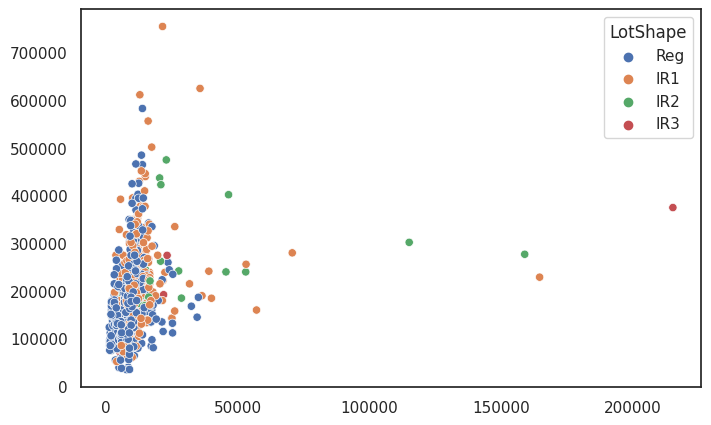

In [7]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_train['LotArea'], y=y_train.values, hue=X_train['LotShape']).set(title="")
plt.xlabel("")
plt.ylabel("")

# Preprocessing the Data

In this section we will preprocess the data filling the missing values and using encoders to change categorical data into numerical one. Then, we will compare the Mean Absolute Error of models trained with data preprocessed in different ways.

## Replacing missing values

Next, we will use `SimpleImputer` to replace missing values with the most frequent value along each column.

In [8]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent') # This strategy replace missing using the most frequent value along each column.

X_train_imp = pd.DataFrame(imputer.fit_transform(X_train))
X_valid_imp = pd.DataFrame(imputer.transform(X_valid))

# Imputation removes the column names, we need to put them back
X_train_imp.columns = X_train.columns
X_valid_imp.columns = X_valid.columns

Simple Imputer turns all column types in objects, it is necessary to change the numerical columns into float or int. 

In [9]:
# Selecting the numerical columns in the original X_train data set
s = (X_train.dtypes != 'object')
num_cols = list(s[s].index)

print(num_cols)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [10]:
# Converting numerical columns from object to float or int
X_train_imp[num_cols]=X_train_imp[num_cols].apply(pd.to_numeric)
X_valid_imp[num_cols]=X_valid_imp[num_cols].apply(pd.to_numeric)

In [11]:
X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    1168 non-null   float64
 3   LotArea        1168 non-null   int64  
 4   Street         1168 non-null   object 
 5   Alley          1168 non-null   object 
 6   LotShape       1168 non-null   object 
 7   LandContour    1168 non-null   object 
 8   Utilities      1168 non-null   object 
 9   LotConfig      1168 non-null   object 
 10  LandSlope      1168 non-null   object 
 11  Neighborhood   1168 non-null   object 
 12  Condition1     1168 non-null   object 
 13  Condition2     1168 non-null   object 
 14  BldgType       1168 non-null   object 
 15  HouseStyle     1168 non-null   object 
 16  OverallQual    1168 non-null   int64  
 17  OverallCond    1168 non-null   int64  
 18  YearBuil

In [12]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 530 to 62
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     292 non-null    int64  
 1   MSZoning       292 non-null    object 
 2   LotFrontage    245 non-null    float64
 3   LotArea        292 non-null    int64  
 4   Street         292 non-null    object 
 5   Alley          20 non-null     object 
 6   LotShape       292 non-null    object 
 7   LandContour    292 non-null    object 
 8   Utilities      292 non-null    object 
 9   LotConfig      292 non-null    object 
 10  LandSlope      292 non-null    object 
 11  Neighborhood   292 non-null    object 
 12  Condition1     292 non-null    object 
 13  Condition2     292 non-null    object 
 14  BldgType       292 non-null    object 
 15  HouseStyle     292 non-null    object 
 16  OverallQual    292 non-null    int64  
 17  OverallCond    292 non-null    int64  
 18  YearBuilt

Now all the missing values in training data are replaced by the most frequent and the numerical columns are restored to its original data type. It is important to note that the missing values are not removed from the validation data, see the info above. Let's deal with the categorical data.

## Encoding Categorical Data

Notice that the dataset contains both numerical and categorical variables.  It is necessary to encode the categorical data before training a model. To compare different models, we'll define the function `score_dataset()`.  This function reports the [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE) from a random forest model.

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0, criterion="absolute_error")
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### Dropping columns with categorical data

The code cell below preprocess the data in `X_train` and `X_valid` to remove columns with categorical data and set the preprocessed DataFrames to `drop_X_train` and `drop_X_valid`, respectively.  

In [14]:
# Printing the data set columns which are objects
s = (X_train_imp.dtypes == 'object')
object_col=list(s[s].index)
print(object_col)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [15]:
# Drop object columns in training and validation data
drop_X_train = X_train_imp.select_dtypes(exclude=['object'])
drop_X_valid = X_valid_imp.select_dtypes(exclude=['object'])
drop_X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,774,0,108,0,0,260,0,0,7,2007
1,20,60.0,6600,5,5,1962,1962,0.0,0,0,...,308,0,0,0,0,0,0,0,8,2009
2,30,80.0,13360,5,7,1921,2006,0.0,713,0,...,432,0,0,44,0,0,0,0,8,2009
3,20,60.0,13265,8,5,2002,2002,148.0,1218,0,...,857,150,59,0,0,0,0,0,7,2008
4,20,118.0,13704,7,5,2001,2002,150.0,0,0,...,843,468,81,0,0,0,0,0,1,2006


The next code cell gives the Mean Absolute Error for this approach.

In [16]:
print("MAE from Approach 1 (Drop categorical variables):")
mae_1 = score_dataset(drop_X_train, drop_X_valid, y_train, y_valid)
print(mae_1)

MAE from Approach 1 (Drop categorical variables):
18286.767431506847


### Ordinal encoding

We cannot write a code to fit an ordinal encoder to the training data, and then use it to transform both the training and validation data, since the `'Condition2'` column present different values in the training and validation data. The code cell below prints the unique entries of `'Condition2'` column, in both the training and validation sets.

In [17]:
print("Unique values in 'Condition2' column in training data:", X_train['Condition2'].unique())
print("\nUnique values in 'Condition2' column in validation data:", X_valid['Condition2'].unique())

Unique values in 'Condition2' column in training data: ['Norm' 'PosA' 'Feedr' 'PosN' 'Artery' 'RRAe']

Unique values in 'Condition2' column in validation data: ['Norm' 'RRAn' 'RRNn' 'Artery' 'Feedr' 'PosN']


The code cell below saves the problematic columns to a Python list `bad_label_cols`.  Likewise, columns that can be safely ordinal encoded are stored in `good_label_cols`.

In [18]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['MiscFeature', 'Functional', 'RoofMatl', 'Condition2']


The next code cell will ordinal encode the data in `X_train` and `X_valid` and set the preprocessed DataFrames to `label_X_train` and `label_X_valid`, respectively.

In [19]:
from sklearn.preprocessing import OrdinalEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train_imp.drop(bad_label_cols, axis=1)
label_X_valid = X_valid_imp.drop(bad_label_cols, axis=1)

# Apply ordinal encoder 
encoder = OrdinalEncoder() # Your code here
label_X_train[good_label_cols] = encoder.fit_transform(X_train_imp[good_label_cols])
label_X_valid[good_label_cols] = encoder.transform(X_valid_imp[good_label_cols])

The next code cell gives the MAE for this approach and allows a comparison between approachs 1 and 2.

In [20]:
print("MAE from approach 1 (Drop categorical variables):")
print(mae_1)
print("MAE from approach 2 (Ordinal Encoding):") 
mae_2 = score_dataset(label_X_train, label_X_valid, y_train, y_valid)
print(mae_2)

MAE from approach 1 (Drop categorical variables):
18286.767431506847
MAE from approach 2 (Ordinal Encoding):
17713.346541095892


**We can seen that encoding categorical data yields better results than removing columns from the dataset.**

### Investigating cardinality

The output below shows the number of unique values in the column for each column with categorical data.  For instance, the `'Street'` column in the training data has two unique values: `'Grvl'` and `'Pave'`, corresponding to a gravel road and a paved road, respectively. We refer to the number of unique entries of a categorical variable as the **cardinality** of that categorical variable.

In [21]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train_imp[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Alley', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('GarageFinish', 3),
 ('PavedDrive', 3),
 ('PoolQC', 3),
 ('MiscFeature', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('MasVnrType', 4),
 ('ExterQual', 4),
 ('BsmtQual', 4),
 ('BsmtCond', 4),
 ('BsmtExposure', 4),
 ('KitchenQual', 4),
 ('Fence', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Electrical', 5),
 ('FireplaceQu', 5),
 ('GarageQual', 5),
 ('GarageCond', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('BsmtFinType1', 6),
 ('BsmtFinType2', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('GarageType', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

For large datasets with many rows, one-hot encoding can greatly expand the size of the dataset.  For this reason, we typically will only one-hot encode columns with relatively low cardinality.  Then, high cardinality columns can either be dropped from the dataset, or we can use ordinal encoding.

Next, we'll only create a one-hot encoding for columns with cardinality less than 10.

In [22]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train_imp[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Neighborhood', 'Exterior2nd', 'Exterior1st']


### One-hot encoding

The next code cell will one-hot encode the data in `X_train` and `X_valid` and set the preprocessed DataFrames to `OH_X_train` and `OH_X_valid`, respectively.

In [23]:
from sklearn.preprocessing import OneHotEncoder

# Use as many lines of code as you need!
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train_imp[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid_imp[low_cardinality_cols]))

OH_cols_train.head()

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# One-hot encoding removed index; put it back
OH_cols_train.index = X_train_imp.index
OH_cols_valid.index = X_valid_imp.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train_imp.drop(object_cols, axis=1)
num_X_valid = X_valid_imp.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,181,182,183,184,185,186,187,188,189,190
0,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,20,60.0,6600,5,5,1962,1962,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,30,80.0,13360,5,7,1921,2006,0.0,713,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,20,60.0,13265,8,5,2002,2002,148.0,1218,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,20,118.0,13704,7,5,2001,2002,150.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


The next code cell gives the MAE for this approach and remember the MAE from the last approaches.

In [25]:
print("MAE from approach 1 (Drop categorical variables):")
print(mae_1)
print("MAE from approach 2 (Ordinal Encoding):") 
print(mae_2)
mae_3 = score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)
print("MAE from Approach 3 (One-Hot Encoding):") 
print(mae_3)

MAE from approach 1 (Drop categorical variables):
18286.767431506847
MAE from approach 2 (Ordinal Encoding):
17713.346541095892


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


MAE from Approach 3 (One-Hot Encoding):
18014.036986301373


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


**Until now, the Ordinal Encoding provides the smallest Mean Absolute Error in the validation data, so we will implement it in a pipeline.**

# Creating a Pipeline

We will create a pipeline to implement the ordinal encoder in a more compact way. Also, we will use `SimpleImputer` to fill missing values with the most frequent value along each column.

In [26]:
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

# Selecting the columns with cardinality less than 10
categorical_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]

# Selecting numerical columns
numerical_cols = [col_name for col_name in X_train.columns if
                      X_train[col_name].dtype in ['int64','float64']]

In [27]:
# Preprocessing for nummerical data:
num_preprocess = SimpleImputer(strategy='most_frequent') # This strategy replace missing using the most frequent value along each column.

# Preprocessing for categorical data:
cat_preprocess = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('encoder', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_preprocess, numerical_cols),
        ('cat', cat_preprocess, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0, criterion="absolute_error")

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17596.003047945207


# Comparing Different Models

Using the pipeline, we can compare different machine learning models varing the parameters or even the algorithm. Let's start with the number of estimators:

In [28]:
# Defining four different models increasing the number of estimators
model_1 = RandomForestRegressor(n_estimators=50, random_state=0, criterion="absolute_error")
model_2 = RandomForestRegressor(n_estimators=75, random_state=0, criterion="absolute_error")
model_3 = RandomForestRegressor(n_estimators=100, random_state=0, criterion="absolute_error")
model_4 = RandomForestRegressor(n_estimators=125, random_state=0, criterion="absolute_error")

models = (model_1,model_2,model_3,model_4)

for model in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    print(model,'MAE:', mean_absolute_error(y_valid, preds))

RandomForestRegressor(criterion='absolute_error', n_estimators=50,
                      random_state=0) MAE: 17734.934178082192
RandomForestRegressor(criterion='absolute_error', n_estimators=75,
                      random_state=0) MAE: 17577.697716894978
RandomForestRegressor(criterion='absolute_error', random_state=0) MAE: 17596.003047945207
RandomForestRegressor(criterion='absolute_error', n_estimators=125,
                      random_state=0) MAE: 17465.372465753422


The best result until now is the model with ***125 estimators***. Let's try to increase more:

In [29]:
model_5 = RandomForestRegressor(n_estimators=150, random_state=0, criterion="absolute_error")
model_6 = RandomForestRegressor(n_estimators=200, random_state=0, criterion="absolute_error")
model_7 = RandomForestRegressor(n_estimators=250, random_state=0, criterion="absolute_error")
model_8 = RandomForestRegressor(n_estimators=300, random_state=0, criterion="absolute_error")

models = (model_5,model_6,model_7,model_8)

for model in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    print(model,'MAE:', mean_absolute_error(y_valid, preds))

RandomForestRegressor(criterion='absolute_error', n_estimators=150,
                      random_state=0) MAE: 17330.520662100455
RandomForestRegressor(criterion='absolute_error', n_estimators=200,
                      random_state=0) MAE: 17466.206130136987
RandomForestRegressor(criterion='absolute_error', n_estimators=250,
                      random_state=0) MAE: 17380.913191780823
RandomForestRegressor(criterion='absolute_error', n_estimators=300,
                      random_state=0) MAE: 17358.963892694064


Here we need to be carefull, although a very small number of estimator cause underfitting, a very hight number of estimators cause overfitting, since the model fits well to training data but not to test data. Moreover, a hight number of estimators require a lot of computational power and time to be tested. Then, we will fix the number of estimators as 300 and change the criterion:

In [30]:
model_4 = RandomForestRegressor(n_estimators=300, random_state=0, criterion="absolute_error")
model_5 = RandomForestRegressor(n_estimators=300, random_state=0, criterion="squared_error")
model_6 = RandomForestRegressor(n_estimators=300, random_state=0, criterion="poisson")

models = (model_4,model_5,model_6)

for model in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    print(model,'MAE:', mean_absolute_error(y_valid, preds))

RandomForestRegressor(criterion='absolute_error', n_estimators=300,
                      random_state=0) MAE: 17358.963892694064
RandomForestRegressor(n_estimators=300, random_state=0) MAE: 17206.4472716895
RandomForestRegressor(criterion='poisson', n_estimators=300, random_state=0) MAE: 27363.006940639272


There are no significant difference between `absolute_error` and `squared_error`, the `poisson` criterion gives a worst MAE. Therefore we will keep the `absolute_error` as the criterion for the Random Forest Regressor. Now, its interesting to compare this model with other regressor, for example the Gradient Boost, with can be implemented trough the XGBRegressor algorithm.

In [31]:
from xgboost import XGBRegressor

model_1_XGB = XGBRegressor(random_state=0, n_estimators=300, learning_rate=0.1)
# A small learning rate allow a big number of estimators
model_2_XGB = XGBRegressor(random_state=0, n_estimators=500, learning_rate=0.01)
model_3_XGB = XGBRegressor(random_state=0, n_estimators=1000, learning_rate=0.001)

models = (model_1_XGB,model_2_XGB,model_3_XGB)

for model in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    print(model,'MAE:', mean_absolute_error(y_valid, preds))


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) MAE: 17411.183821168663
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             im

**The model with a lowest MAE we've found is the Gradient Boost with 500 estimators and learning rate 0.01**

The XGBRegressor `early_stopping_round` option offers a way to automatically find the ideal value for n_estimators. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. However, the early stopping cannot be passed through a pipeline, so we will restore the training data and impute/encode again.

In [32]:
# Redefining the training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

# Drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X_train.drop(cols_with_missing, axis=1, inplace=True)
X_valid.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))

# Drop categorical columns that will not be encoded
enco_X_train = X_train.drop(bad_label_cols, axis=1)
enco_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder 
encoder = OrdinalEncoder() 
enco_X_train[good_label_cols] = encoder.fit_transform(X_train[good_label_cols])
enco_X_valid[good_label_cols] = encoder.transform(X_valid[good_label_cols])

In [33]:
#model_4_XGB = XGBRegressor(random_state=0, n_estimators=3000, learning_rate=0.001, early_stopping_round=5)
model_4_XGB = XGBRegressor(random_state=0, n_estimators=10000, learning_rate=0.01, early_stopping_round=5)

model_4_XGB.fit(enco_X_train, y_train, eval_set=[(enco_X_valid,y_valid)], verbose=False)
preds = model_4_XGB.predict(enco_X_valid)
print('model_4_XGB','MAE:', mean_absolute_error(y_valid, preds))

[22:49:13] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


model_4_XGB MAE: 15623.331188463186


**This is the best model we've found!**

# Generating test predictions and submiting the results


It is necessary to apply the ordinal encode to the test data set: 

In [34]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_test[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))

# Drop categorical columns that will not be encoded
enco_X_train = X_train.drop(bad_label_cols, axis=1)
enco_X_test = X_test.drop(bad_label_cols, axis=1)

# Apply ordinal encoder 
encoder = OrdinalEncoder() 
enco_X_train[good_label_cols] = encoder.fit_transform(X_train[good_label_cols])
enco_X_test[good_label_cols] = encoder.transform(X_test[good_label_cols])

In [35]:
# Generating predicitions from the final model:
final_model = model_4_XGB
final_model.fit(enco_X_train, y_train)
preds_test = final_model.predict(enco_X_test)

[22:49:58] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [36]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)